# Badania kd-tree, ball tree

## 1. Generowanie zestawu danych uczących

Wygeneruj zestawy danych uczących (zawierających dwie klasy):

* kostkę n-wymiarową (2, 3, 4, 6, 8, 10) podzieloną hiperpłaszczyzną:
  - kwadrat podzielony na dwie równe cześci prostą
  - szcześcian podzielony na dwie równe części przez płaszczyznę
  - ...
* szachownica składająca się z 4, 9, 16, 25 kwadratów

Wygenerować różne rozmiary powyższych zbiorów. Dane należy wygenerować w dwóch wersjach: oryginalnej i zaburzone szumem gaussowskim.

Wskazówka: Punkt (a) można zrealizować w postaci jednej funkcji przyjmującej jako parametry wymiarowość przestrzeni, liczbę danych, infomację czy należy do danych dodać szum itp. Dla kostki o długości krawędzi 1 hiperpłaszczyzna musi przechodziz przez punkt $\frac{1}{2}, ..., \frac{1}{2}$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Generowanie płaszczyzny przechodzącej przez środek

#### Przykład dla dwóch wymiarów:

Generujemy losową prostą przechodzącą przez punkt $\frac{1}{2}, \frac{1}{2}$
Prosta opisana jest równanie

$$y = ax + b$$

Znamy punkty $y = \frac{1}{2}$ i $x = \frac{1}{2}$ więc losujemy współczynnik $a$. Z tego otrzymujemy równanie na $b$.

$$b = y - ax$$

Mamy już losową prostą przechodzącą przez punkt środkowy.

#### Przykład dla trzech wymiarów

Płaszczyzna dwuwymiarowa opisana jest wzorem

$$y = a_1 x_1 + a_2 + x_2 + a_0 $$

Losujemy współczynniki $a_1$, $a_2$ oraz pod wartości $y$, $x_1$, $x_2$ przykładamy wartość $0.5$. Daje nam to równanie na wyraz wolny.

$$a_0 = y - \sum_i a_i x_i $$

W poniższym kodzie wyraz wolny, czyli $a_0$, lub $b$ w przpadku prostej oznaczany jest jako `coeff_0`. Współczynniki równania są reprezentowane przez wektor `coeffs`.


In [2]:
def generate_hiperplane(n_dimension):
    """ Generate random hiperplane that goes trough middle point """
    middle_point = np.array([0.5 for _ in range(n_dimension-1)])
    coeffs = np.random.rand(n_dimension-1)
    coeff_0 = 0.5 - np.sum(coeffs * middle_point)
    return coeff_0, coeffs
    
def generate_cube(n_dimension, n_samples):
    x = np.random.rand(n_samples, n_dimension)
    return x

### Nadawanie etykiet próbkom

Mając równanie płaszczyzny, np:

$$y = \frac{1}{6}x + \frac{5}{12}$$

Sprawdzamy warunek, czy dla próbki $a$ spełniony jest warunek $\frac{1}{6}x_a + \frac{5}{12} > y_a$. Dzięki temu przydzielamy próbkom dwie klasy w zależności od pozycji względem prostej/płaszczyzny separacji.

In [3]:
def generate_data(n_dimension=2, n_samples=100, noise=False):
    samples = generate_cube(n_dimension, n_samples)
    b, coeffs = generate_hiperplane(n_dimension)

    labels = np.sum(coeffs * samples[:, 0:-1], axis=1) + b > samples[:, -1]
    if noise:
        samples = samples + np.random.randn(n_samples, n_dimension)*0.08
    return samples, labels, (b, coeffs)

#### Przykład wygenerowanych danych dla $n=2$ z szumem

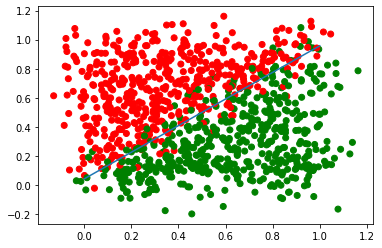

In [4]:
samples, labels, (b, coeffs) = generate_data(n_dimension=2, n_samples=1000, noise=True)
x = np.linspace(0, 1, 100)
y = coeffs[0]*x + b

colors = ['red' if l == 0 else 'green' for l in labels]

plt.plot(x, y)
plt.scatter(samples[:, 0], samples[:, 1], color=colors)
plt.show()

#### Przykład wygenerowanych danych dla $n=3$

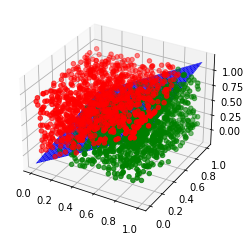

In [5]:
from mpl_toolkits.mplot3d import Axes3D

n_dimension = 3
samples = generate_cube(n_dimension, 2000)
b, coeffs = generate_hiperplane(n_dimension)

labels = np.sum(coeffs * samples[:, 0:-1], axis=1) + b > samples[:, -1]
colors = ['red' if l == 0 else 'green' for l in labels]

xs = np.linspace(0, 1, 100)
zs = np.linspace(0, 1, 100)

X, Z = np.meshgrid(xs, zs)
Y = coeffs[0] * X + coeffs[1] * Z + b

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Z, Y, color='blue')
ax.scatter(samples[:, 0], samples[:, 1], samples[:, 2], color=colors)
plt.show()

Może się wydawać, że wyznaczona niebieska płaszczyzna nie separuje zielonych i czerwonych punktów, ale to kwestia rotacji wykresu.

### Generowanie szachownicy

Implementacja zainspirowana rozwiązaniem: https://stackoverflow.com/questions/60019462/create-checkerboard-distribution-with-python

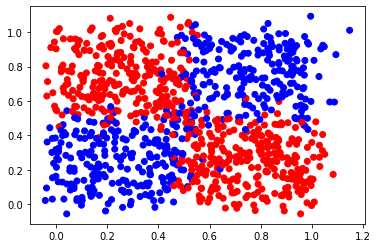

In [7]:
from numpy import sin

def generate_checkerboard(n_size, n_samples, noise=True):
    """Generate checkerboard of size n_size x n_size"""
    x = np.random.uniform(-(n_size//2)*np.pi, (n_size//2)*np.pi, size=(n_samples, 2))
    mask = np.logical_or(np.logical_and(sin(x[:, 0]) > 0.0, sin(x[:, 1]) > 0.0),
                         np.logical_and(sin(x[:, 0]) < 0.0, sin(x[:, 1]) < 0.0))
    # normalization
    x = (x-np.min(x))/(np.max(x)-np.min(x))
    y = np.eye(2)[1*mask]
    y = y[:, 0]  # the second column is inverse, we don't need that
    
    if noise:
        x = x + np.random.randn(x.shape[0], x.shape[1])*0.05
    
    return x, y
    
x, y = generate_checkerboard(2, 1000)
plt.scatter(x[:, 0], x[:, 1], c=y, cmap="bwr")
plt.show()